In [92]:
# --------------------------------------------------------------------------------
# MSCS-634-B01 Advanced Big Data and Data Mining - Full Pipeline
# Data Collection, Cleaning, Exploration, Modeling, and Final Report
# --------------------------------------------------------------------------------

# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from io import StringIO

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Configure plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


In [93]:
# --------------------------------------------------------------------------------
# Data Collection, Cleaning, and Exploration
# --------------------------------------------------------------------------------

# STEP 2: Load Dataset and Inspect
df = pd.read_csv('healthcare_dataset.csv')

# Display the shape of dataset (rows, columns)
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (55500, 15)


In [94]:
# Display the first few rows
print("\nHead of Dataset:")
df.head()


Head of Dataset:


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [95]:
# Check data types and basic info
print("\nDataset Info:")
buf = StringIO()
df.info(buf=buf)
print(buf.getvalue())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
me

In [96]:
# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64


In [97]:
# STEP 3: Data Cleaning

# 3.1 Standardize column names (lowercase, remove spaces)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# 3.2 Remove duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Duplicate Rows Found: {duplicate_count}")

Duplicate Rows Found: 534


In [98]:
if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")
    print(f"Dataset Shape after removing duplicates: {df.shape}")

Duplicates removed.
Dataset Shape after removing duplicates: (54966, 15)


In [99]:
# 3.3 Clean text columns (strip spaces, proper case)
text_columns = ['name', 'gender', 'blood_type', 'medical_condition',
                'admission_type', 'test_results', 'doctor', 'hospital', 'insurance_provider', 'medication']

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()

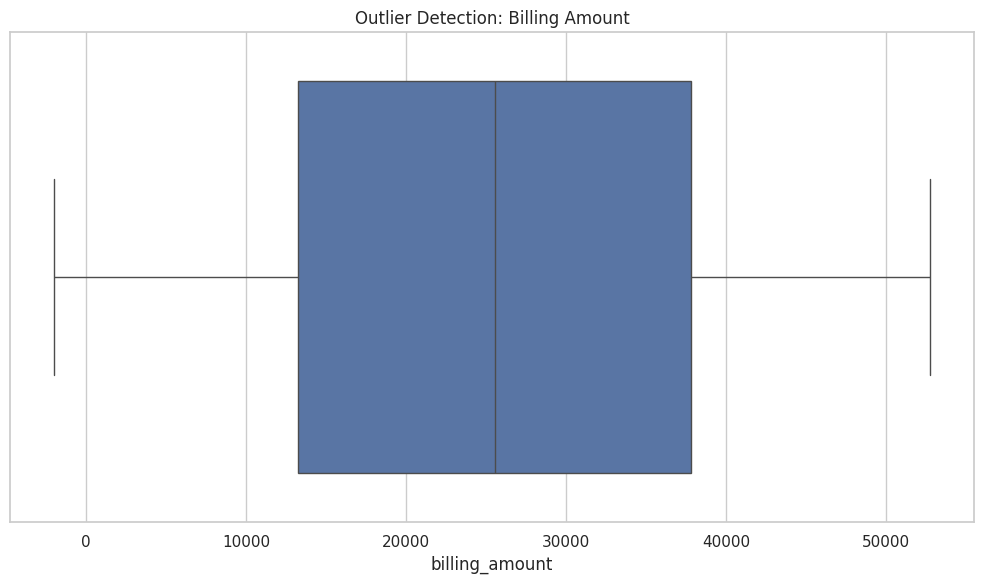

In [100]:
# 3.4 Handle noisy data
# Example: Visualize outliers in billing_amount
sns.boxplot(x=df['billing_amount'])
plt.title('Outlier Detection: Billing Amount')
plt.tight_layout()
plt.show()

In [101]:
# Remove extreme outliers: Above 99th percentile
q_high = df['billing_amount'].quantile(0.99)
df = df[df['billing_amount'] <= q_high]
print(f"Dataset Shape after removing extreme outliers: {df.shape}")

Dataset Shape after removing extreme outliers: (54416, 15)


In [102]:
# STEP 4: Exploratory Data Analysis (EDA)

# 4.1 Summary Statistics
print("Summary Statistics:")
df.describe()

Summary Statistics:


,age,billing_amount,room_number
count,54416.000000,54416.000000,54416.000000
mean,51.540870,25292.054081,301.138636
std,19.608549,14055.503426,115.209522
min,13.000000,-2008.492140,101.000000
25%,35.000000,13127.277426,202.000000
50%,52.000000,25284.418338,302.000000
75%,68.000000,37429.149239,401.000000
max,89.000000,49849.329750,500.000000


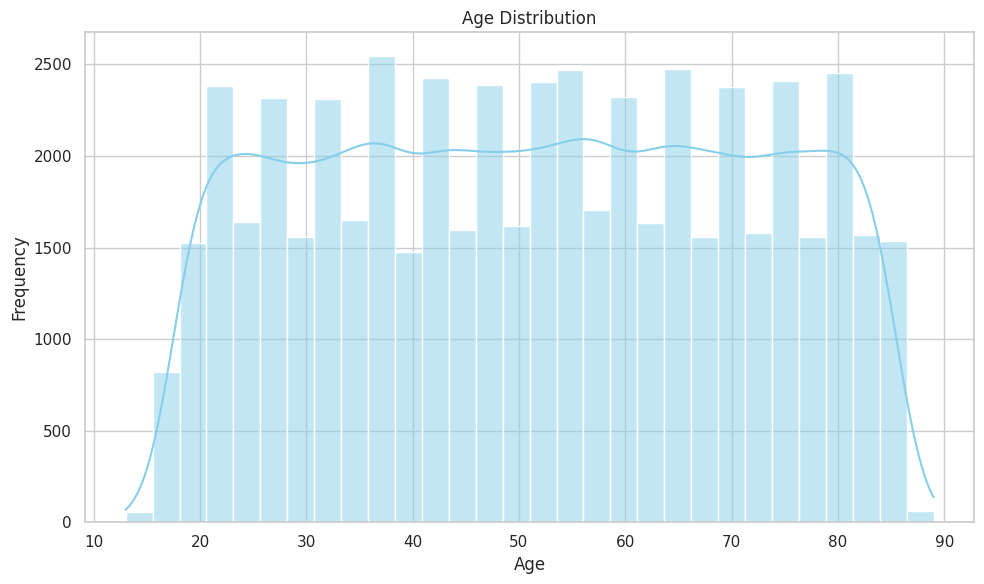

In [103]:
# 4.2 Visualize distributions

# Age Distribution
sns.histplot(df['age'], kde=True, bins=30, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

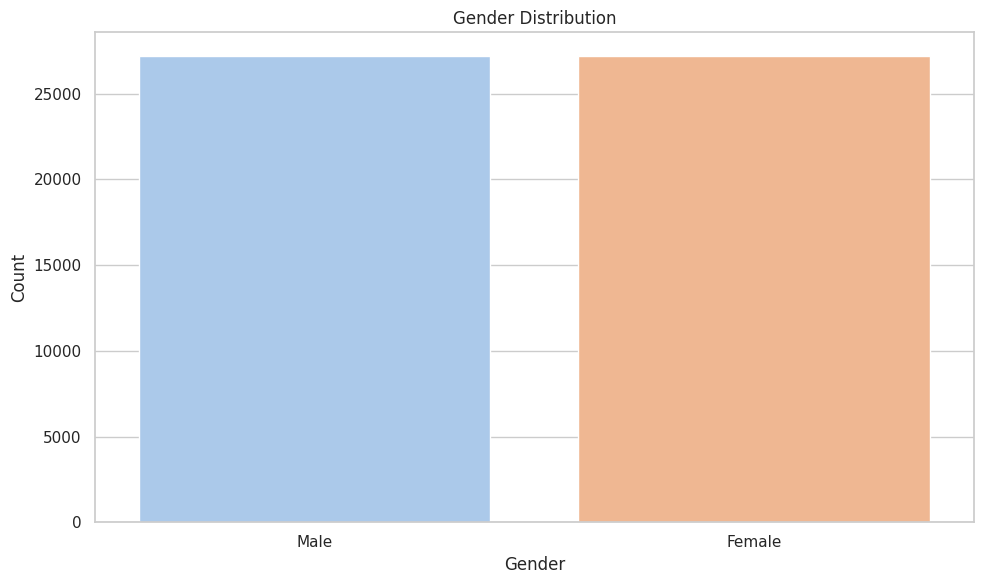

In [104]:
# Gender Distribution
sns.countplot(x='gender', data=df, palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

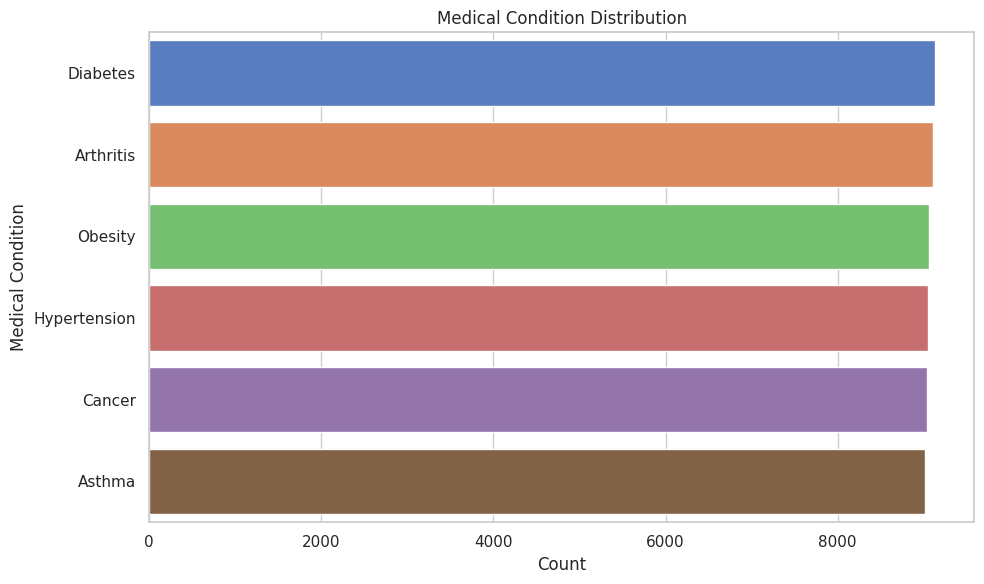

In [105]:
# Medical Condition Counts
sns.countplot(y='medical_condition', data=df, palette='muted', order=df['medical_condition'].value_counts().index)
plt.title('Medical Condition Distribution')
plt.xlabel('Count')
plt.ylabel('Medical Condition')
plt.tight_layout()
plt.show()

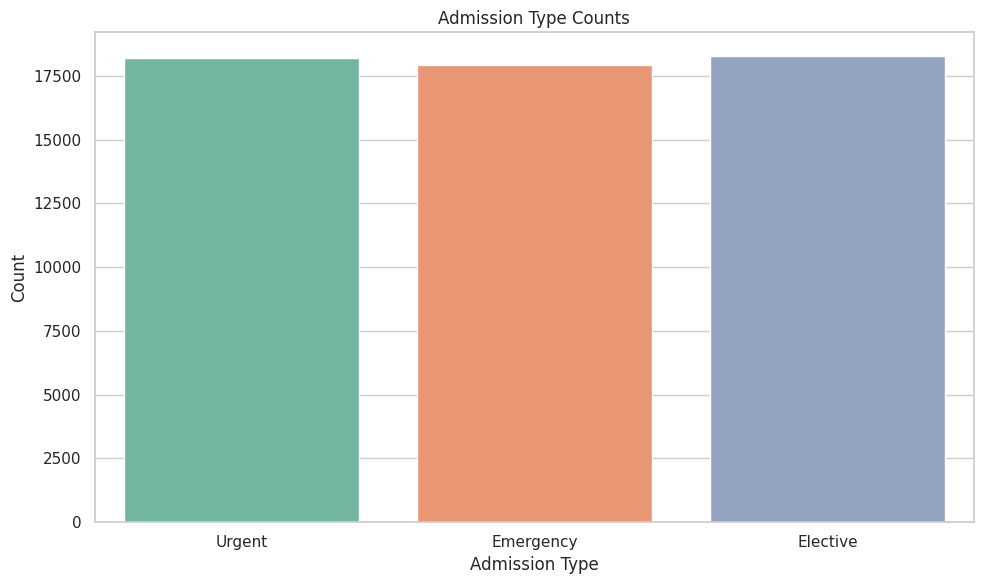

In [106]:
# Admission Types
sns.countplot(x='admission_type', data=df, palette='Set2')
plt.title('Admission Type Counts')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

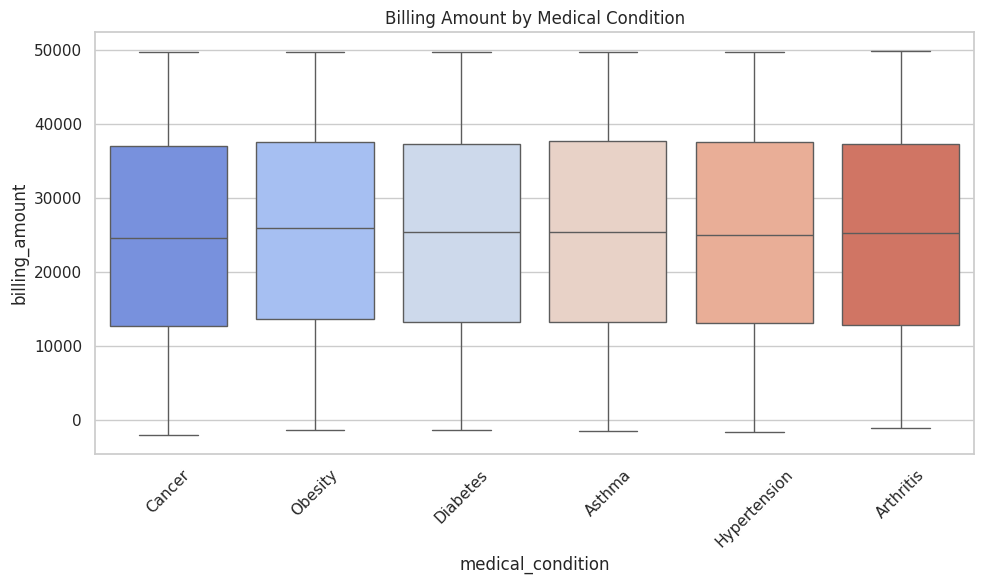

In [107]:
# 4.3 Feature Relationships

# Billing Amount by Medical Condition
sns.boxplot(x='medical_condition', y='billing_amount', data=df, palette='coolwarm')
plt.title('Billing Amount by Medical Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

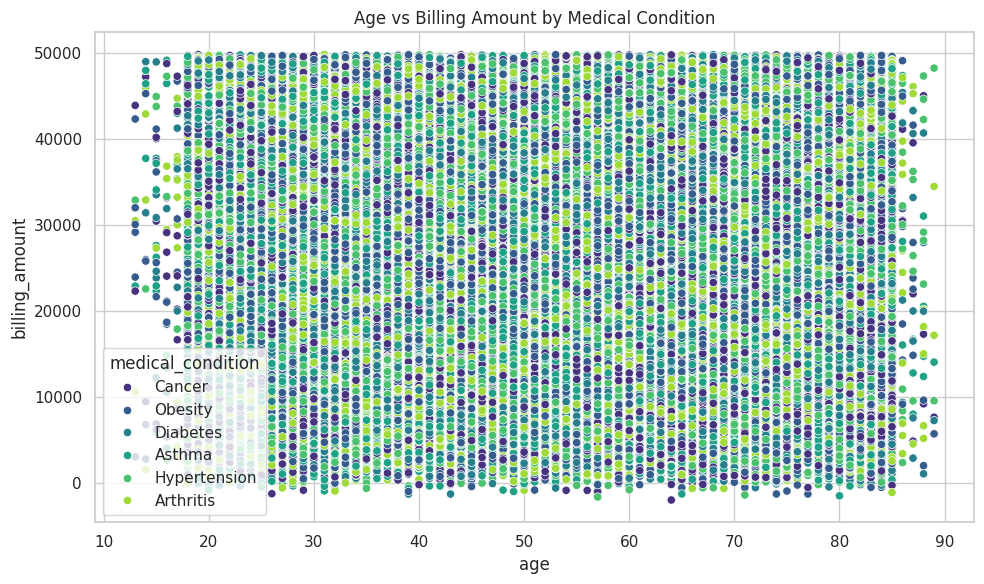

In [108]:
# Age vs Billing Amount Scatter Plot
sns.scatterplot(x='age', y='billing_amount', hue='medical_condition', data=df, palette='viridis')
plt.title('Age vs Billing Amount by Medical Condition')
plt.tight_layout()
plt.show()

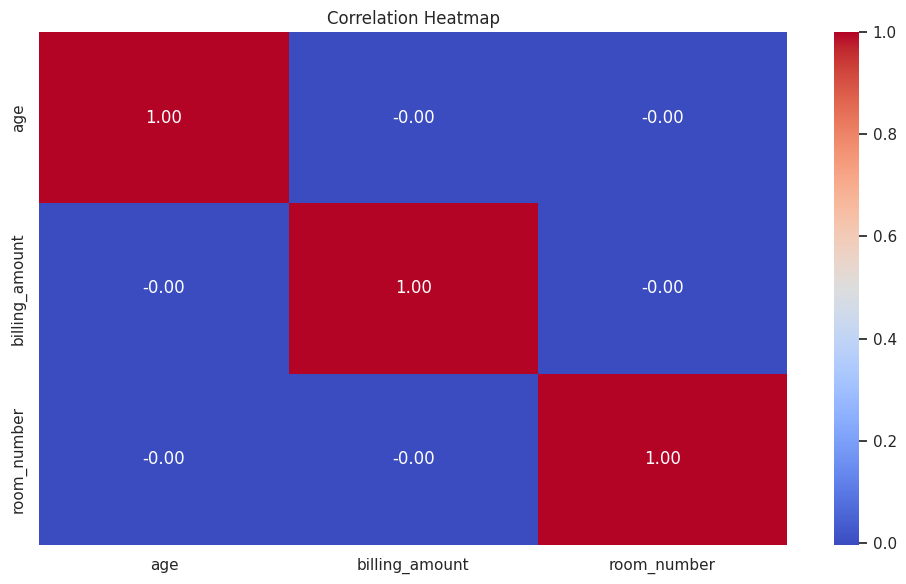

In [109]:
# Correlation Matrix Heatmap
numeric_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [110]:
# --------------------------------------------------------------------------------
# Regression Analysis and Evaluation - Healthcare Cost Estimation
# --------------------------------------------------------------------------------

upper_limit = df['billing_amount'].quantile(0.99)
df = df[df['billing_amount'] <= upper_limit]

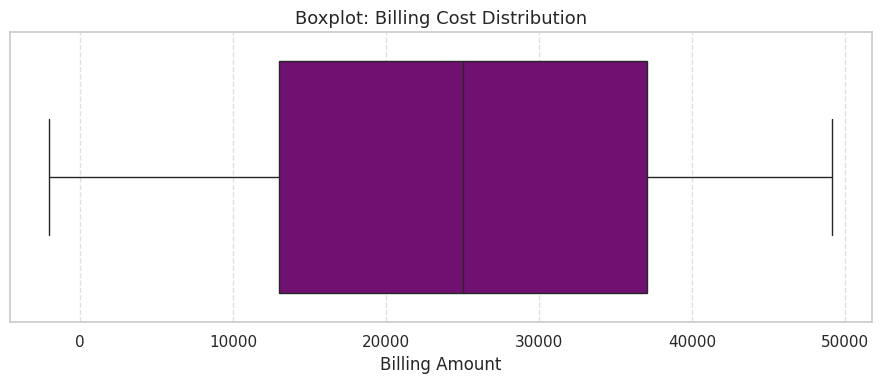

In [111]:
# Visualization
plt.figure(figsize=(9, 4))
sns.boxplot(x=df['billing_amount'], color="purple")
plt.title('Boxplot: Billing Cost Distribution', fontsize=13)
plt.xlabel("Billing Amount")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [112]:
# Derived Feature: Age band
bins = [0, 20, 40, 60, 100]
labels = ['Teen', 'Adult', 'Midlife', 'Elderly']
df['age_band'] = pd.cut(df['age'], bins=bins, labels=labels)

# Split Inputs and Target Variable
input_features = ['age', 'gender', 'medical_condition', 'insurance_provider',
                  'admission_type', 'age_band']
target_variable = df['billing_amount']

X_train, X_test, y_train, y_test = train_test_split(
    df[input_features], target_variable, test_size=0.2, random_state=100)

In [113]:
# Pipeline Configuration
categoricals = ['gender', 'medical_condition', 'insurance_provider', 'admission_type', 'age_band']
numericals = ['age']

processing_steps = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), numericals),
    ('encode', OneHotEncoder(drop='first'), categoricals)
])

# Build and Train Models
model_list = {
    'LinearRegression': Pipeline(steps=[('transform', processing_steps),
                                        ('model', LinearRegression())]),
    'RidgeRegression': Pipeline(steps=[('transform', processing_steps),
                                       ('model', Ridge(alpha=1.0))]),
    'LassoRegression': Pipeline(steps=[('transform', processing_steps),
                                       ('model', Lasso(alpha=0.1))])
}

In [114]:
# Evaluate Model Performance
evaluation_report = {}

for model_name, pipeline in model_list.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    mse_val = mean_squared_error(y_test, predictions)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_test, predictions)
    cross_val_r2 = cross_val_score(pipeline, df[input_features], target_variable,
                                   cv=5, scoring='r2').mean()

    evaluation_report[model_name] = {
        'MSE': mse_val,
        'RMSE': rmse_val,
        'R-Squared': r2_val,
        'CV R-Squared': cross_val_r2
    }

summary_df = pd.DataFrame(evaluation_report).T
print("\nComparative Model Results:\n")
print(summary_df.round(3))


Comparative Model Results:

                           MSE       RMSE  R-Squared  CV R-Squared
LinearRegression  1.922466e+08  13865.303        0.0          -0.0
RidgeRegression   1.922466e+08  13865.303        0.0          -0.0
LassoRegression   1.922470e+08  13865.316        0.0          -0.0


In [115]:
# --------------------------------------------------------------------------------
# Classification, Clustering, Association Rule Mining
# --------------------------------------------------------------------------------

df = df[df['billing_amount'] <= df['billing_amount'].quantile(0.99)]

In [116]:
# # Classification: Predict 'test_results'
X = df[['age', 'gender', 'medical_condition', 'insurance_provider', 'admission_type', 'age_band']]
y = df['test_results']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# # Preprocessing
categorical_features = ['gender', 'medical_condition', 'insurance_provider', 'admission_type', 'age_band']
numeric_features = ['age']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

In [118]:
# Decision Tree
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_pipeline.fit(X_train, y_train)
dt_preds = dt_pipeline.predict(X_test)

In [119]:
# Naive Bayes
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])
nb_pipeline.fit(X_train, y_train)
nb_preds = nb_pipeline.predict(X_test)

In [120]:
# Hyperparameter tuning (Decision Tree)
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_dt_model = grid_search.best_estimator_
best_dt_preds = best_dt_model.predict(X_test)

In [121]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

evaluate_model(y_test, dt_preds, "Decision Tree")


--- Decision Tree ---
Confusion Matrix:
 [[1571 1146  828]
 [1586 1050  910]
 [1602 1103  871]]

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.33      0.44      0.38      3545
Inconclusive       0.32      0.30      0.31      3546
      Normal       0.33      0.24      0.28      3576

    accuracy                           0.33     10667
   macro avg       0.33      0.33      0.32     10667
weighted avg       0.33      0.33      0.32     10667

Accuracy: 0.32736476985094215
F1 Score: 0.32215192745596244


In [122]:
evaluate_model(y_test, nb_preds, "Naive Bayes")


--- Naive Bayes ---
Confusion Matrix:
 [[1678  907  960]
 [1686  890  970]
 [1681  954  941]]

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.33      0.47      0.39      3545
Inconclusive       0.32      0.25      0.28      3546
      Normal       0.33      0.26      0.29      3576

    accuracy                           0.33     10667
   macro avg       0.33      0.33      0.32     10667
weighted avg       0.33      0.33      0.32     10667

Accuracy: 0.328958470047811
F1 Score: 0.32166956460134616


In [123]:
evaluate_model(y_test, best_dt_preds, "Tuned Decision Tree")


--- Tuned Decision Tree ---
Confusion Matrix:
 [[1704  905  936]
 [1727  878  941]
 [1686  930  960]]

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.33      0.48      0.39      3545
Inconclusive       0.32      0.25      0.28      3546
      Normal       0.34      0.27      0.30      3576

    accuracy                           0.33     10667
   macro avg       0.33      0.33      0.32     10667
weighted avg       0.33      0.33      0.32     10667

Accuracy: 0.33205212337114465
F1 Score: 0.3243865158403808


In [124]:
# ROC Curve
if len(y.unique()) == 2:
    # map classes for ROC (assumes 'Normal'/'Abnormal' as in example)
    mapping = {cls: i for i, cls in enumerate(sorted(y.unique()))}
    y_mapped = y_test.map(mapping)
    if hasattr(best_dt_model, "predict_proba"):
        y_probs = best_dt_model.predict_proba(X_test)
        positive_index = 1 if y_probs.shape[1] > 1 else 0
        fpr, tpr, _ = roc_curve(y_mapped, y_probs[:, positive_index])
        plt.plot(fpr, tpr, label="Tuned Decision Tree")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Clustering with KMeans (age & billing_amount)
cluster_data = df[['age', 'billing_amount']].dropna()
cluster_scaled = StandardScaler().fit_transform(cluster_data)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cluster_scaled)

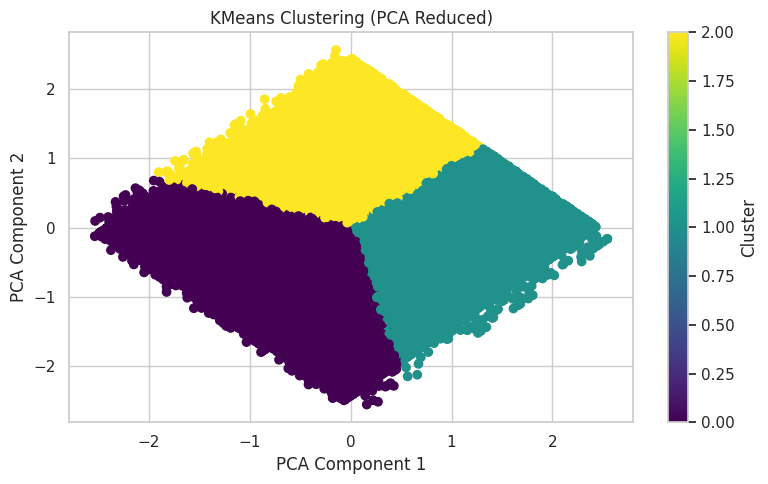

In [125]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(cluster_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('KMeans Clustering (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [126]:
# Association Rule Mining
basket = df[['medical_condition', 'medication']].dropna().values.tolist()
te = TransactionEncoder()
basket_te = te.fit_transform(basket)
df_basket = pd.DataFrame(basket_te, columns=te.columns_)

frequent_items = apriori(df_basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=0.5)

# Show top 10 rules sorted by confidence
rules.sort_values(by='confidence', ascending=False, inplace=True)
top_rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)
print("\nTop 10 Association Rules (by confidence):")
print(top_rules)


Top 10 Association Rules (by confidence):
       antecedents    consequents   support  confidence      lift
30        (Cancer)      (Lipitor)  0.034688    0.208286  1.035935
24        (Asthma)  (Paracetamol)  0.034276    0.207186  1.034029
1      (Arthritis)      (Aspirin)  0.034595    0.206514  1.036108
58       (Obesity)   (Penicillin)  0.034295    0.205644  1.033200
44  (Hypertension)    (Ibuprofen)  0.034070    0.204848  1.023126
38      (Diabetes)      (Lipitor)  0.034126    0.203830  1.013772
28        (Cancer)    (Ibuprofen)  0.033882    0.203445  1.016121
42      (Diabetes)   (Penicillin)  0.033901    0.202486  1.017334
49  (Hypertension)  (Paracetamol)  0.033657    0.202368  1.009982
7      (Arthritis)  (Paracetamol)  0.033882    0.202261  1.009450
